# Notebook per Predicció de Matèria Seca (MS) en Patates

Aquest notebook entrena una xarxa neuronal per predir el percentatge de 
matèria seca a partir de les característiques de color i NIR de les patates.

Columnes del dataset:
- id_mostra: identificador únic
- ruta_imatges: ruta a la imatge
- color_promig_R, color_promig_G, color_promig_B: colors mitjans RGB
- desviació_R, desviació_G, desviació_B: desviacions estàndard dels canals
- canal_NIR: valor del canal infraroig proper
- MS_experimental: percentatge de matèria seca (TARGET)
- lot: identificador del lot
- data: data de captura

## 1. IMPORTACIÓ DE LLIBRERIES

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

# Configuració per reproducibilitat
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU disponible: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.13.0
GPU disponible: []


## 2. CÀRREGA I EXPLORACIÓ DE DADES


=== INFORMACIÓ DEL DATASET ===
Nombre de mostres: 10

Columnes disponibles:
['id_mostra', 'ruta_imatges', 'color_promig_R', 'color_promig_G', 'color_promig_B', 'desviació_R', 'desviació_G', 'desviació_B', 'canal_NIR', 'MS_experimental', 'lot', 'data']

Primeres files:
   id_mostra          ruta_imatges  color_promig_R  color_promig_G  \
0          1  data/images/L1_1.png           158.3           132.7   
1          2  data/images/L1_2.png           162.9           136.4   
2          3  data/images/L1_3.png           149.6           128.3   
3          4  data/images/L2_4.png           171.2           142.5   
4          5  data/images/L2_5.png           167.8           140.1   

   color_promig_B  desviació_R  desviació_G  desviació_B  canal_NIR  \
0            96.4         12.5         10.2          8.7      0.742   
1           101.2         11.8          9.6          7.9      0.755   
2            93.1         13.1         11.0          9.2      0.731   
3           107.8        

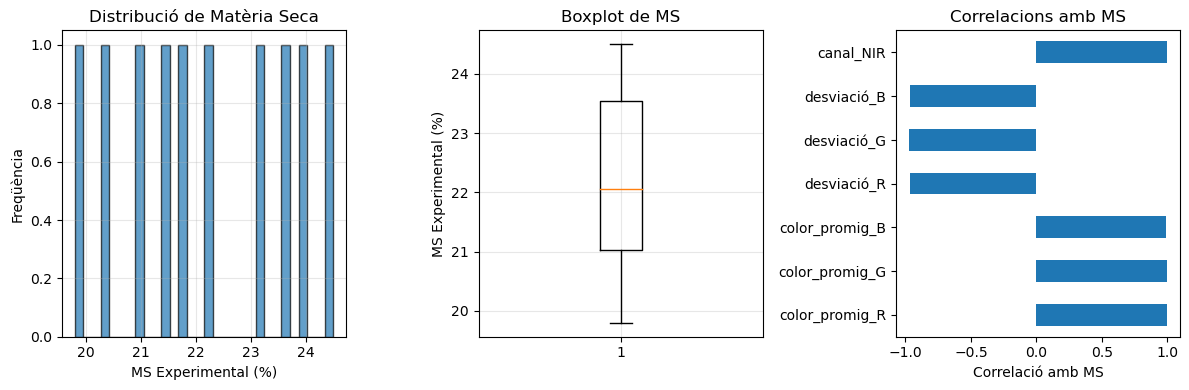

In [4]:
# IMPORTANT: Canvia aquesta ruta per la del teu dataset
os.chdir("D:/potato-dry-matter-optics-ml")
RUTA_DATASET = "data/input/training/training_set.csv"

# Carregar les dades
df = pd.read_csv(RUTA_DATASET)

print("\n=== INFORMACIÓ DEL DATASET ===")
print(f"Nombre de mostres: {len(df)}")
print(f"\nColumnes disponibles:\n{df.columns.tolist()}")
print(f"\nPrimeres files:")
print(df.head())

# Estadístiques descriptives
print("\n=== ESTADÍSTIQUES DESCRIPTIVES ===")
print(df.describe())

# Comprovar valors nuls
print("\n=== VALORS NULS ===")
print(df.isnull().sum())

# Visualització de la distribució de MS
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(df['MS_experimental'], bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('MS Experimental (%)')
plt.ylabel('Freqüència')
plt.title('Distribució de Matèria Seca')
plt.grid(alpha=0.3)

plt.subplot(1, 3, 2)
plt.boxplot(df['MS_experimental'])
plt.ylabel('MS Experimental (%)')
plt.title('Boxplot de MS')
plt.grid(alpha=0.3)

plt.subplot(1, 3, 3)
# Correlació entre features i MS
features_cols = ['color_promig_R', 'color_promig_G', 'color_promig_B', 
                 'desviació_R', 'desviació_G', 'desviació_B', 'canal_NIR']
correlations = df[features_cols + ['MS_experimental']].corr()['MS_experimental'].drop('MS_experimental')
correlations.plot(kind='barh')
plt.xlabel('Correlació amb MS')
plt.title('Correlacions amb MS')
plt.tight_layout()
plt.show()

## 3. PREPARACIÓ DE LES DADES

In [5]:
# Seleccionar les columnes d'entrada (features) i sortida (target)
feature_cols = ['color_promig_R', 'color_promig_G', 'color_promig_B',
                'desviació_R', 'desviació_G', 'desviació_B', 'canal_NIR']
target_col = 'MS_experimental'

# Extreure X (inputs) i y (target)
X = df[feature_cols].values
y = df[target_col].values

print("\n=== PREPARACIÓ DE DADES ===")
print(f"Shape de X (features): {X.shape}")
print(f"Shape de y (target): {y.shape}")

# Separar en conjunt d'entrenament (80%) i validació (20%)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nConjunt d'entrenament: {X_train.shape[0]} mostres")
print(f"Conjunt de validació: {X_val.shape[0]} mostres")

# Normalització (StandardScaler)
# És important normalitzar per ajudar a la xarxa neuronal a convergir millor
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)

y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).flatten()

print("\n=== NORMALITZACIÓ COMPLETADA ===")
print(f"Mitjana X_train: {X_train_scaled.mean(axis=0)}")
print(f"Desviació estàndard X_train: {X_train_scaled.std(axis=0)}")


=== PREPARACIÓ DE DADES ===
Shape de X (features): (10, 7)
Shape de y (target): (10,)

Conjunt d'entrenament: 8 mostres
Conjunt de validació: 2 mostres

=== NORMALITZACIÓ COMPLETADA ===
Mitjana X_train: [-2.19269047e-15  1.30451205e-15 -1.77635684e-15 -1.16573418e-15
  5.55111512e-16  4.71844785e-16  3.38618023e-15]
Desviació estàndard X_train: [1. 1. 1. 1. 1. 1. 1.]


## 4. DEFINICIÓ DEL MODEL

In [6]:
def crear_model(n_features, n_neurons_1=64, n_neurons_2=32, 
                learning_rate=0.001, dropout_rate=0.2):
    """
    Crea una xarxa neuronal densa per regressió.
    
    Paràmetres:
    -----------
    n_features : int
        Nombre de features d'entrada
    n_neurons_1 : int
        Neurones a la primera capa oculta
    n_neurons_2 : int
        Neurones a la segona capa oculta
    learning_rate : float
        Taxa d'aprenentatge per Adam
    dropout_rate : float
        Taxa de dropout per regularització
    
    Retorna:
    --------
    model : keras.Model
        Model compilat
    """
    model = keras.Sequential([
        # Capa d'entrada
        layers.Input(shape=(n_features,)),
        
        # Primera capa oculta
        layers.Dense(n_neurons_1, activation='relu', name='hidden_1'),
        layers.Dropout(dropout_rate, name='dropout_1'),
        
        # Segona capa oculta
        layers.Dense(n_neurons_2, activation='relu', name='hidden_2'),
        layers.Dropout(dropout_rate, name='dropout_2'),
        
        # Tercera capa oculta (opcional)
        layers.Dense(16, activation='relu', name='hidden_3'),
        
        # Capa de sortida (regressió, 1 neurona sense activació)
        layers.Dense(1, name='output')
    ])
    
    # Compilar el model
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='mse',  # Mean Squared Error per regressió
        metrics=['mae']  # Mean Absolute Error com a mètrica addicional
    )
    
    return model

# Crear el model amb configuració per defecte
n_features = X_train_scaled.shape[1]
model = crear_model(n_features)

print("\n=== ARQUITECTURA DEL MODEL ===")
model.summary()


=== ARQUITECTURA DEL MODEL ===
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_1 (Dense)            (None, 64)                512       
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 hidden_2 (Dense)            (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 hidden_3 (Dense)            (None, 16)                528       
                                                                 
 output (Dense)              (None, 1)                 17        
                                                                 
Total params: 3137 (12.2

## 5. ENTRENAMENT DEL MODEL

In [7]:
# Callbacks per millorar l'entrenament
callbacks = [
    # EarlyStopping: para l'entrenament si no millora en 20 èpoques
    EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True,
        verbose=1
    ),
    
    # ReduceLROnPlateau: redueix la taxa d'aprenentatge si no millora
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-7,
        verbose=1
    )
]

print("\n=== COMENÇANT ENTRENAMENT ===")

# Entrenar el model
history = model.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=200,
    batch_size=16,
    callbacks=callbacks,
    verbose=1
)

print("\n=== ENTRENAMENT COMPLETAT ===")


=== COMENÇANT ENTRENAMENT ===
Epoch 1/200
1/1 [==============================] - 1s 766ms/step - loss: 0.7150 - mae: 0.6780 - val_loss: 0.8385 - val_mae: 0.7523 - lr: 0.0010
Epoch 2/200
1/1 [==============================] - 0s 23ms/step - loss: 0.4228 - mae: 0.5707 - val_loss: 0.6571 - val_mae: 0.6631 - lr: 0.0010
Epoch 3/200
1/1 [==============================] - 0s 22ms/step - loss: 0.4654 - mae: 0.5511 - val_loss: 0.5158 - val_mae: 0.5842 - lr: 0.0010
Epoch 4/200
1/1 [==============================] - 0s 23ms/step - loss: 0.4876 - mae: 0.5520 - val_loss: 0.3909 - val_mae: 0.5034 - lr: 0.0010
Epoch 5/200
1/1 [==============================] - 0s 23ms/step - loss: 0.4131 - mae: 0.4688 - val_loss: 0.2890 - val_mae: 0.4275 - lr: 0.0010
Epoch 6/200
1/1 [==============================] - 0s 22ms/step - loss: 0.0593 - mae: 0.2252 - val_loss: 0.2172 - val_mae: 0.3636 - lr: 0.0010
Epoch 7/200
1/1 [==============================] - 0s 23ms/step - loss: 0.1188 - mae: 0.2531 - val_loss: 0.158

## 6. VISUALITZACIÓ DEL PROCÉS D'ENTRENAMENT

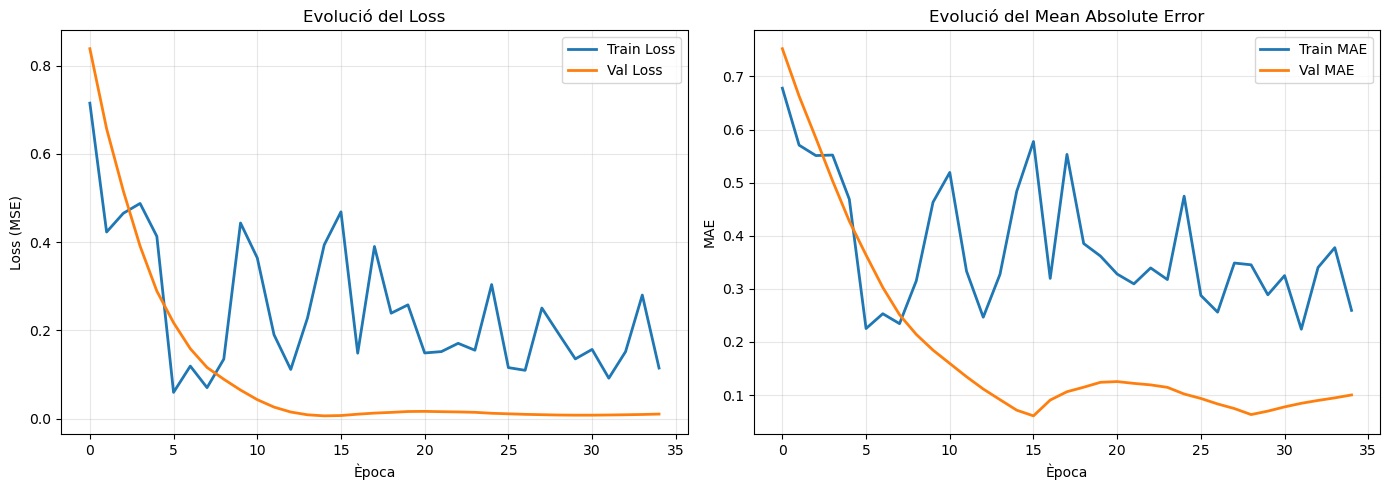

In [8]:
plt.figure(figsize=(14, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
plt.xlabel('Època')
plt.ylabel('Loss (MSE)')
plt.title('Evolució del Loss')
plt.legend()
plt.grid(alpha=0.3)

# MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE', linewidth=2)
plt.plot(history.history['val_mae'], label='Val MAE', linewidth=2)
plt.xlabel('Època')
plt.ylabel('MAE')
plt.title('Evolució del Mean Absolute Error')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 7. AVALUACIÓ DEL MODEL

In [9]:
# Prediccions en el conjunt de validació (normalitzat)
y_val_pred_scaled = model.predict(X_val_scaled, verbose=0).flatten()

# Desnormalitzar les prediccions per obtenir valors reals
y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled.reshape(-1, 1)).flatten()

# Calcular mètriques
mape = mean_absolute_percentage_error(y_val, y_val_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
mae = np.mean(np.abs(y_val - y_val_pred))
r2 = r2_score(y_val, y_val_pred)

print("\n=== RESULTATS EN EL CONJUNT DE VALIDACIÓ ===")
print(f"MAPE (Mean Absolute Percentage Error): {mape*100:.2f}%")
print(f"RMSE (Root Mean Squared Error): {rmse:.3f}")
print(f"MAE (Mean Absolute Error): {mae:.3f}")
print(f"R² (Coeficient de determinació): {r2:.3f}")

# Interpretació dels resultats
print("\n=== INTERPRETACIÓ ===")
if mape < 0.15:
    print("✓ Excel·lent! MAPE < 15% - El model és molt precís")
elif mape < 0.20:
    print("✓ Acceptable. MAPE entre 15-20% - El model és força bo")
else:
    print("✗ Millorable. MAPE > 20% - Caldria més dades o millor preprocessament")


=== RESULTATS EN EL CONJUNT DE VALIDACIÓ ===
MAPE (Mean Absolute Percentage Error): 0.46%
RMSE (Root Mean Squared Error): 0.114
MAE (Mean Absolute Error): 0.105
R² (Coeficient de determinació): 0.989

=== INTERPRETACIÓ ===
✓ Excel·lent! MAPE < 15% - El model és molt precís


## 8. VISUALITZACIÓ DE PREDICCIONS

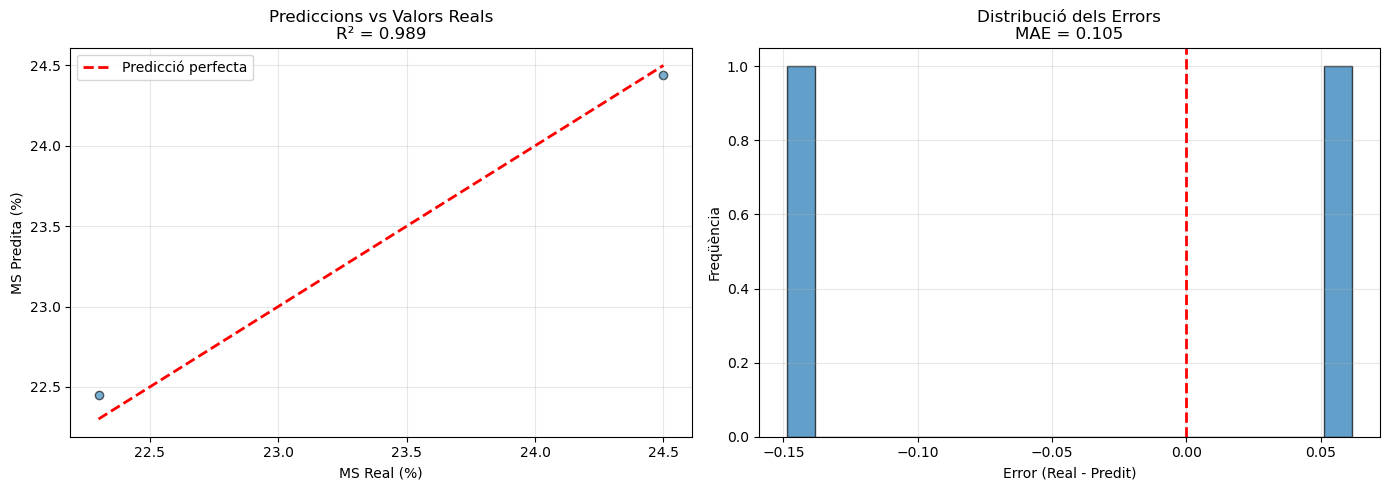

In [10]:
plt.figure(figsize=(14, 5))

# Gràfic de dispersió: valor real vs predit
plt.subplot(1, 2, 1)
plt.scatter(y_val, y_val_pred, alpha=0.6, edgecolor='black')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 
         'r--', linewidth=2, label='Predicció perfecta')
plt.xlabel('MS Real (%)')
plt.ylabel('MS Predita (%)')
plt.title(f'Prediccions vs Valors Reals\nR² = {r2:.3f}')
plt.legend()
plt.grid(alpha=0.3)

# Distribució dels errors
plt.subplot(1, 2, 2)
errors = y_val - y_val_pred
plt.hist(errors, bins=20, edgecolor='black', alpha=0.7)
plt.axvline(x=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Error (Real - Predit)')
plt.ylabel('Freqüència')
plt.title(f'Distribució dels Errors\nMAE = {mae:.3f}')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 9. GRIDSEARCH PER OPTIMITZACIÓ (OPCIONAL)

In [11]:
def gridsearch_manual(X_train, y_train, X_val, y_val, configuracions):
    """
    Cerca manual de la millor configuració d'hiperparàmetres.
    
    Paràmetres:
    -----------
    configuracions : list of dict
        Llista de diccionaris amb diferents configuracions a provar
    
    Retorna:
    --------
    millor_config : dict
        Millor configuració trobada
    resultats : list
        Resultats de totes les configuracions
    """
    resultats = []
    
    for i, config in enumerate(configuracions):
        print(f"\n--- Provant configuració {i+1}/{len(configuracions)} ---")
        print(f"Config: {config}")
        
        # Crear i entrenar model
        model_temp = crear_model(n_features, **config)
        
        history_temp = model_temp.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=100,
            batch_size=16,
            callbacks=[EarlyStopping(monitor='val_loss', patience=15, 
                                    restore_best_weights=True, verbose=0)],
            verbose=0
        )
        
        # Avaluar
        y_pred_temp = model_temp.predict(X_val, verbose=0).flatten()
        y_pred_real = scaler_y.inverse_transform(y_pred_temp.reshape(-1, 1)).flatten()
        y_val_real = scaler_y.inverse_transform(y_val.reshape(-1, 1)).flatten()
        
        mape_temp = mean_absolute_percentage_error(y_val_real, y_pred_real)
        
        resultats.append({
            'config': config,
            'mape': mape_temp,
            'val_loss': min(history_temp.history['val_loss'])
        })
        
        print(f"MAPE: {mape_temp*100:.2f}%")
    
    # Trobar la millor configuració
    millor = min(resultats, key=lambda x: x['mape'])
    print(f"\n=== MILLOR CONFIGURACIÓ ===")
    print(f"Config: {millor['config']}")
    print(f"MAPE: {millor['mape']*100:.2f}%")
    
    return millor, resultats


# Exemple de configuracions a provar (descomenta per executar)
"""
configuracions_exemple = [
    {'n_neurons_1': 32, 'n_neurons_2': 16, 'learning_rate': 0.001, 'dropout_rate': 0.1},
    {'n_neurons_1': 64, 'n_neurons_2': 32, 'learning_rate': 0.001, 'dropout_rate': 0.2},
    {'n_neurons_1': 128, 'n_neurons_2': 64, 'learning_rate': 0.0005, 'dropout_rate': 0.2},
    {'n_neurons_1': 64, 'n_neurons_2': 32, 'learning_rate': 0.01, 'dropout_rate': 0.3},
]

millor_config, tots_resultats = gridsearch_manual(
    X_train_scaled, y_train_scaled, 
    X_val_scaled, y_val_scaled,
    configuracions_exemple
)
"""

"\nconfiguracions_exemple = [\n    {'n_neurons_1': 32, 'n_neurons_2': 16, 'learning_rate': 0.001, 'dropout_rate': 0.1},\n    {'n_neurons_1': 64, 'n_neurons_2': 32, 'learning_rate': 0.001, 'dropout_rate': 0.2},\n    {'n_neurons_1': 128, 'n_neurons_2': 64, 'learning_rate': 0.0005, 'dropout_rate': 0.2},\n    {'n_neurons_1': 64, 'n_neurons_2': 32, 'learning_rate': 0.01, 'dropout_rate': 0.3},\n]\n\nmillor_config, tots_resultats = gridsearch_manual(\n    X_train_scaled, y_train_scaled, \n    X_val_scaled, y_val_scaled,\n    configuracions_exemple\n)\n"

## 10. FUNCIÓ PER PREDIR NOVES MOSTRES

In [12]:
def predir_ms(nova_mostra, scaler_X, scaler_y, model):
    """
    Prediu el % de MS per una nova mostra.
    
    Paràmetres:
    -----------
    nova_mostra : dict o array
        Si és dict, ha de tenir les claus: 'color_promig_R', 'color_promig_G', 
        'color_promig_B', 'desviació_R', 'desviació_G', 'desviació_B', 'canal_NIR'
        Si és array, ha de tenir els valors en aquest ordre
    
    Retorna:
    --------
    ms_predita : float
        Percentatge de matèria seca predit
    """
    # Convertir a array si és diccionari
    if isinstance(nova_mostra, dict):
        X_nova = np.array([[
            nova_mostra['color_promig_R'],
            nova_mostra['color_promig_G'],
            nova_mostra['color_promig_B'],
            nova_mostra['desviació_R'],
            nova_mostra['desviació_G'],
            nova_mostra['desviació_B'],
            nova_mostra['canal_NIR']
        ]])
    else:
        X_nova = np.array(nova_mostra).reshape(1, -1)
    
    # Normalitzar
    X_nova_scaled = scaler_X.transform(X_nova)
    
    # Predir
    y_pred_scaled = model.predict(X_nova_scaled, verbose=0)
    
    # Desnormalitzar
    y_pred = scaler_y.inverse_transform(y_pred_scaled).flatten()[0]
    
    return y_pred


# Exemple d'ús
print("\n=== EXEMPLE DE PREDICCIÓ ===")
mostra_exemple = {
    'color_promig_R': 150.0,
    'color_promig_G': 140.0,
    'color_promig_B': 120.0,
    'desviació_R': 20.0,
    'desviació_G': 18.0,
    'desviació_B': 15.0,
    'canal_NIR': 0.65
}

ms_predita = predir_ms(mostra_exemple, scaler_X, scaler_y, model)
print(f"Mostra: {mostra_exemple}")
print(f"MS predita: {ms_predita:.2f}%")


=== EXEMPLE DE PREDICCIÓ ===
Mostra: {'color_promig_R': 150.0, 'color_promig_G': 140.0, 'color_promig_B': 120.0, 'desviació_R': 20.0, 'desviació_G': 18.0, 'desviació_B': 15.0, 'canal_NIR': 0.65}
MS predita: 17.66%


## 11. GUARDAR EL MODEL I SCALERS

In [13]:
# Guardar el model
model.save('model_prediccio_ms.keras')
print("\n✓ Model guardat com 'model_prediccio_ms.keras'")

# Guardar els scalers amb numpy
import pickle
with open('scaler_X.pkl', 'wb') as f:
    pickle.dump(scaler_X, f)
with open('scaler_y.pkl', 'wb') as f:
    pickle.dump(scaler_y, f)
print("✓ Scalers guardats com 'scaler_X.pkl' i 'scaler_y.pkl'")

print("\n=== PROCÉS COMPLETAT ===")
print("Per carregar el model en el futur:")
print("  model = keras.models.load_model('model_prediccio_ms.keras')")
print("  with open('scaler_X.pkl', 'rb') as f: scaler_X = pickle.load(f)")
print("  with open('scaler_y.pkl', 'rb') as f: scaler_y = pickle.load(f)")



✓ Model guardat com 'model_prediccio_ms.keras'
✓ Scalers guardats com 'scaler_X.pkl' i 'scaler_y.pkl'

=== PROCÉS COMPLETAT ===
Per carregar el model en el futur:
  model = keras.models.load_model('model_prediccio_ms.keras')
  with open('scaler_X.pkl', 'rb') as f: scaler_X = pickle.load(f)
  with open('scaler_y.pkl', 'rb') as f: scaler_y = pickle.load(f)
